# Load data

define packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import os
import glob

define paths

In [2]:
datadir = '/home/barbora/Documents/Projects/2022_Neuromatch/data/'
imgdir =  '/home/barbora/Documents/Projects/2022_Neuromatch/img/'

load

In [3]:
#functional connectivity matricies 
FC_zip = np.load(os.path.join(datadir,'vectorized_FC_alltask_allsub.npz'))

# extract the array and rehspe
FC = FC_zip['arr_0']
X = FC.reshape(FC.shape[0]*FC.shape[1], FC.shape[2])

Initial run of the PCA

In [25]:
### DO NOT EVER RUN THIS CODE -- this is a giant PCA and its gonaa be painful -- load the PCA weights from the .sav file
# from sklearn.decomposition import PCA
# pca = PCA(whiten=False, svd_solver='auto', 
#     tol=0.0, iterated_power='auto', 
#     n_oversamples=10, 
#     power_iteration_normalizer='auto', 
#     random_state=42)

# pca.fit(X)
# import pickle
# pickle.dump(pca, open(os.path.join(datadir,'pca.sav'), 'wb'))

PCA(random_state=42)

In [4]:
# load pca from .sav file
import pickle
pca = pickle.load(open(os.path.join(datadir,'pca.sav'), 'rb'))

<AxesSubplot:>

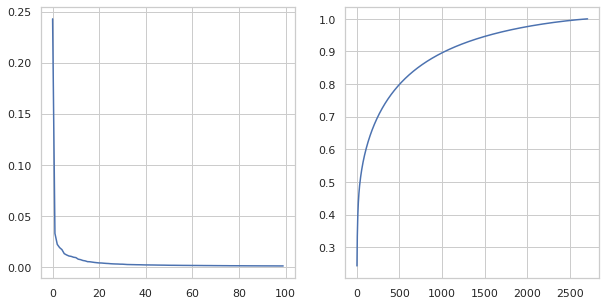

In [5]:
# plot explained variance ratio
sns.set_theme(style='whitegrid')
fix,ax = plt.subplots(1,2,figsize=(10,5))
sns.lineplot(x=range(0,100),y=pca.explained_variance_ratio_[0:100], ax=ax[0], markers=True, dashes=False)
sns.lineplot(x=range(X.shape[0]),y=np.cumsum(pca.explained_variance_ratio_), ax=ax[1], markers=True, dashes=False)

In [6]:
# create vector that contains task labels
labels=np.zeros([1, X.shape[0]])
no_subjects = X.shape[0]/8
start=0
for i in range(1,9):
    labels[0][start:int(no_subjects*i)] = i
    start =  int(no_subjects*i)

In [7]:
# get scores for PCA and save
scores = pca.transform(X)
#np.save(os.path.join(datadir,'scores_PCA.npy'), scores)

<AxesSubplot:>

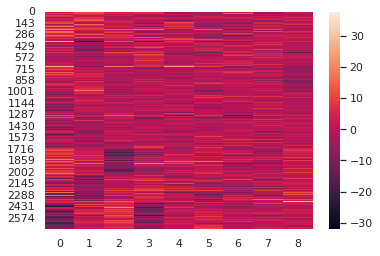

In [8]:
# initial look onto the score of the first few components
sns.heatmap(scores[:,1:10])
# Looks promising!

In [26]:
# create temporary pandas frame for plotting
temp_file = pd.DataFrame(scores[:,1:10])
temp_file['task'] = np.squeeze(labels)
temp_file['task'] = temp_file['task'].astype('category')

temp_file_melted = temp_file.melt(id_vars='task', value_vars=list(range(1,10)), var_name='component', value_name='score')

<AxesSubplot:xlabel='component', ylabel='score'>

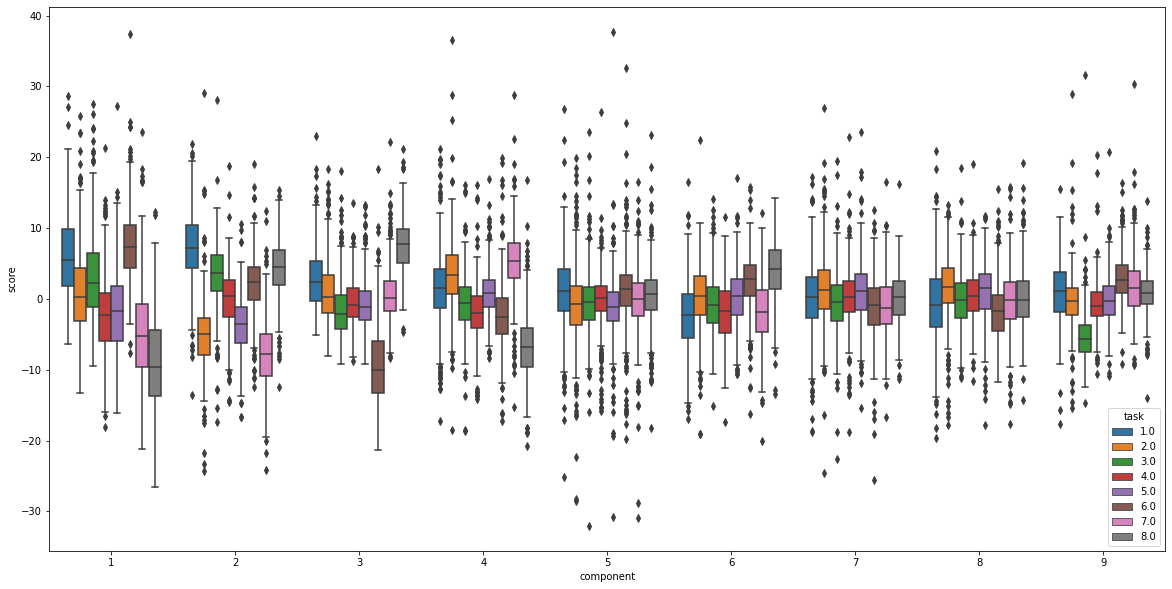

In [42]:
fig = plt.subplots(figsize=(20,10))
sns.boxplot(x='component', y='score', data=temp_file_melted, hue='task')

# Running multinomial logistic regression - eight classes

In [25]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score

In [26]:
# Divide dataset into training and test sets
labels = np.squeeze(labels)
X_train, X_test, y_train, y_test = train_test_split(scores, labels, test_size=0.33, random_state=42, shuffle=True, stratify=labels)

# L1

In [70]:
sizes_to_try = [1,10,100,1000]
lr_scores = []
lr_final_scores = np.zeros([len(sizes_to_try), X_test.shape[0]])

for i, ino_vals in enumerate(sizes_to_try):
    # Run logistic regression on the train set
    lr = LogisticRegressionCV(penalty='l1', solver='liblinear', max_iter=1000, fit_intercept=True, random_state=42, cv=10).fit(X_train[:,0:ino_vals], 
        y_train)

    # Predict on the test set
    lr_final_scores[i,:] = lr.predict(X_test[:,0:ino_vals])
    lr_scores.append(lr.score(X_test[:,0:ino_vals], y_test))

In [85]:
# Save the classification of the models
#with open(os.path.join(datadir,'LR_L1.npy'), 'wb') as f:
#    pickle.dump([X_train, X_test, y_train, y_test, lr_final_scores, lr_scores], f)

with open(os.path.join(datadir,'LR_L1.npy'), 'rb') as f:
     [X_train, X_test, y_train, y_test, lr_final_scores, lr_scores] = pickle.load(f)

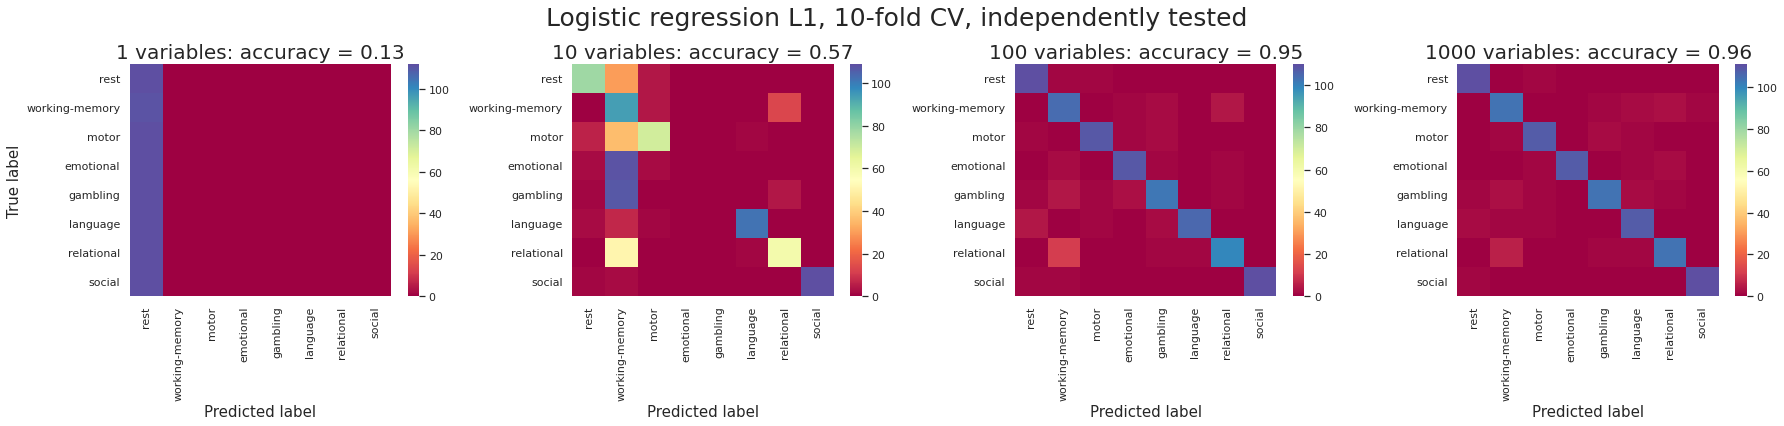

In [116]:
# Plot the results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

task_names = ['rest', 'working-memory', 'motor',  'emotional','gambling',  'language', 'relational', 'social']
sizes_to_try = [1,10,100,1000]

ncols = 4
fig,ax = plt.subplots(1,ncols,figsize=(25,6))

for iplot in range(ncols):
    sns.heatmap(confusion_matrix(y_test, lr_final_scores[iplot,:]), cmap='Spectral', ax=ax[iplot], xticklabels=task_names, yticklabels=task_names)
    ax[iplot].set_title(str(sizes_to_try[iplot])+' variables: accuracy = %.2f' % lr_scores[iplot], fontsize=20)
    ax[iplot].set_xlabel('Predicted label', fontsize=15)
    if iplot == 0:
        ax[iplot].set_ylabel('True label', fontsize=15)

fig.suptitle('Logistic regression L1, 10-fold CV, independently tested', fontsize=25)

fig.tight_layout()

In [117]:
lr = LogisticRegressionCV(penalty='l1', solver='liblinear', max_iter=1000, fit_intercept=True, random_state=42, cv=10).fit(X_train[:,0:100], 
        y_train)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

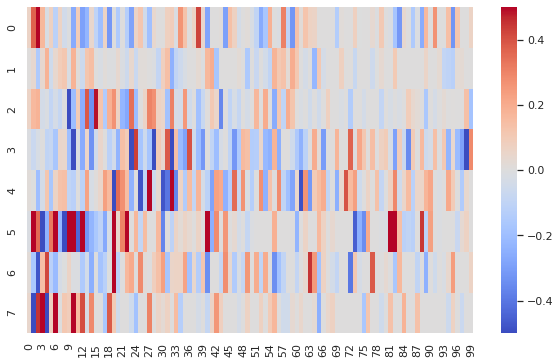

In [140]:
ax, fig = plt.subplots(1,1,figsize=(10,6))
sns.heatmap(lr.coef_, cmap='coolwarm',vmin=-0.5,vmax=0.5)
plt.axhline(y=a)

# Transformation back into thematrix

In [16]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

0 0 0
1 0 1
2 0 2
3 1 0
4 1 1
5 1 2
6 2 0
7 2 1
8 2 2


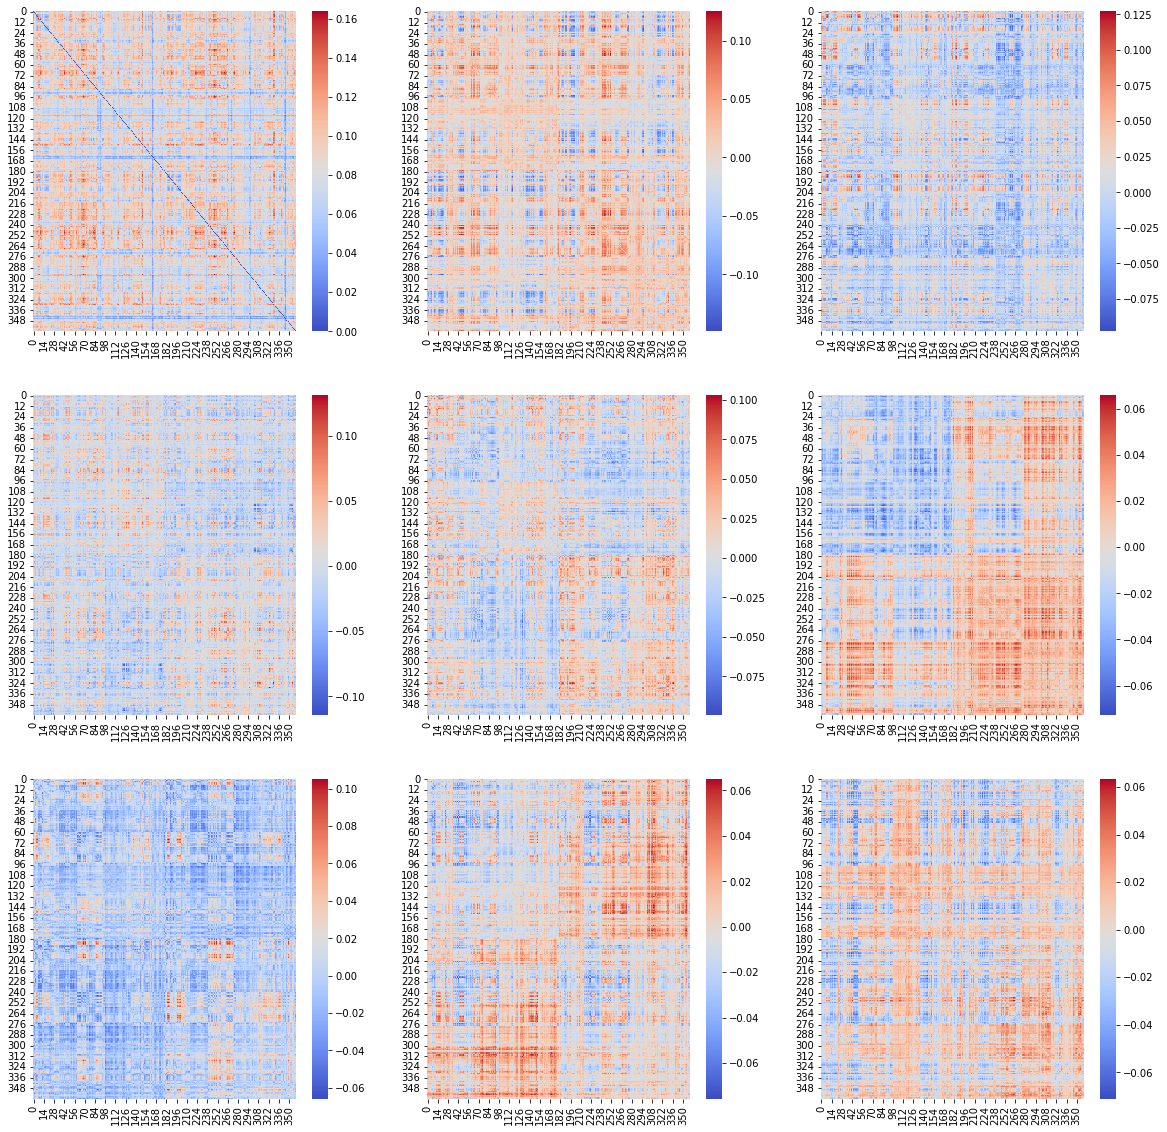

In [36]:
# De-vecroize the loadings and plot matrices
nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(20,20))

for iplot in range(0,9):
    x = iplot//ncols
    y = iplot%ncols

    print(str(iplot),str(x),str(y))
    # de-vectorize
    n_regions = 360
    mat = np.zeros([n_regions, n_regions])
    mat[np.triu_indices(n_regions, 1)] = np.squeeze(loadings[:,iplot])
    mat = mat+mat.T
    
    sns.heatmap(mat, cmap='coolwarm', ax=ax[x,y])



In [52]:
# Loading the textfile containing network mapping
yeo_regions = pd.read_table(os.path.join(datadir, 'glasser_to_yeo7.txt'), sep=';', header=None)
yeo_regions[2] = yeo_regions[2].astype('category')

In [262]:
# Create network templates
templates = np.zeros((360,360,yeo_regions[2].unique().shape[0]))

for nnetwork, inetwork in enumerate(list(yeo_regions[2].dtypes.categories)):
    print(str(nnetwork),inetwork)
    columns = (yeo_regions[yeo_regions[2] == inetwork][0]-1).to_numpy()
    for irow in columns:      
        templates[irow,columns,nnetwork] = 1    

0 7Networks_1_Vis
1 7Networks_2_SomMot
2 7Networks_3_DorsAttn
3 7Networks_4_SalVentAttn
4 7Networks_5_Limbic
5 7Networks_6_Control
6 7Networks_7_Default
7 FreeSurfer_Defined_Medial_Wall_None


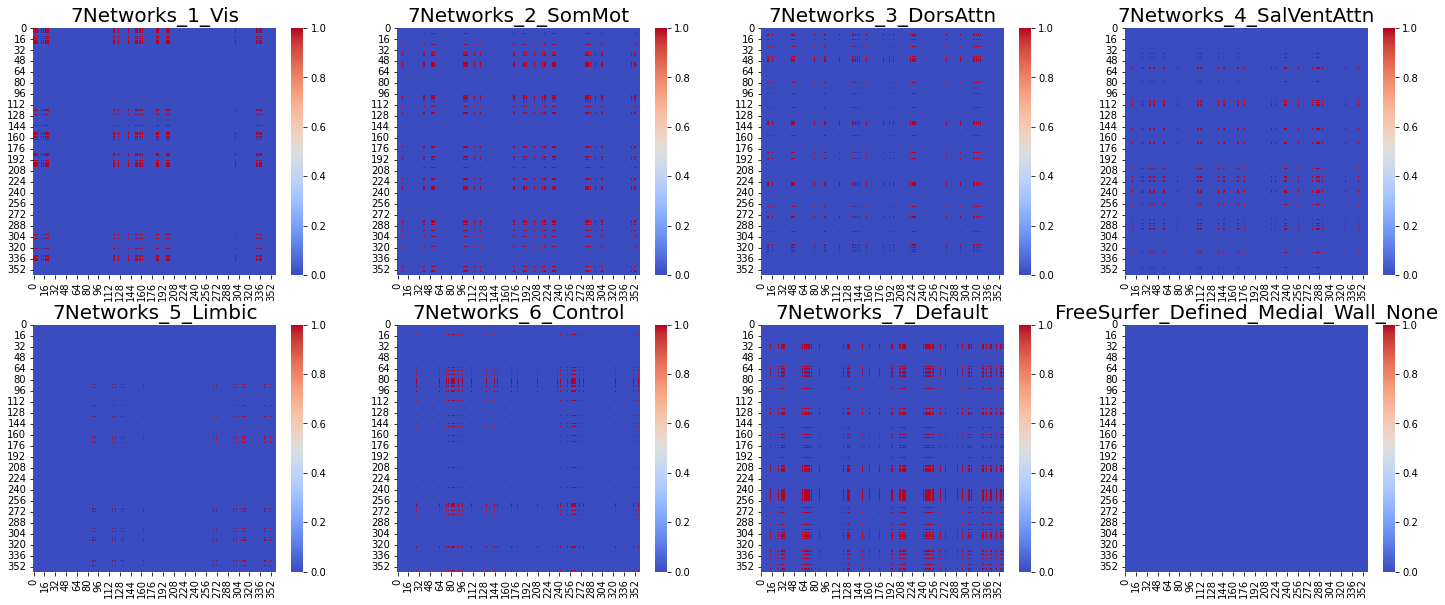

In [264]:
# Plot the network templates
nrows = 2
ncols = 4
fig, ax = plt.subplots(nrows, ncols, figsize=(25,10))
for iplot in range(0,yeo_regions[2].unique().shape[0]):
    x = iplot//ncols
    y = iplot%ncols

    #print(str(iplot),str(x),str(y))    
    sns.heatmap(templates[:,:,iplot], ax=ax[x,y])
    ax[x,y].set_title((yeo_regions[2].dtypes.categories[iplot]), fontsize=20)
    

In [265]:
# Save the classification of the models
with open(os.path.join(datadir,'network_templates.npy'), 'wb') as f:
    pickle.dump([templates, yeo_regions[2].unique()], f)

# with open(os.path.join(datadir,'network_templates.npy'), 'rb') as f:
#     [templates, network_labels] = pickle.load(f)

In [266]:
# create a 3d array of matricized loadings
n_networks =  len(yeo_regions[2].unique())
n_components = 100
n_regions = 360

m_loadings = np.zeros((n_regions, n_regions, n_components))
temp = np.zeros((n_regions, n_regions))

for icomp in range(0,n_components):
    # de-vectorize
    temp[np.triu_indices(n_regions, 1)] = np.squeeze(loadings[:,icomp])
    m_loadings[:,:,icomp] = temp+temp.T


In [267]:
# compute the pseudo "similarity" of loadings matrices with the networks templates
network_dist = np.zeros((n_components, n_networks))

for imat in range(m_loadings.shape[2]):
    for inetwork in range(templates.shape[2]):
        network_dist[imat, inetwork] = (np.abs(m_loadings[:,:,imat]) * templates[:,:,inetwork]).sum() / templates[:,:,inetwork].sum()
        

# Plotting loadings across networks -- not normalizing across component

In [269]:
network_labels = list(yeo_regions[2].dtypes.categories)
df_network_dist = pd.DataFrame(network_dist, columns=network_labels, index=range(1,n_components+1))
df_network_dist['component'] = df_network_dist.index


In [270]:
df_melted = df_network_dist.melt('component')

<AxesSubplot:xlabel='value', ylabel='variable'>

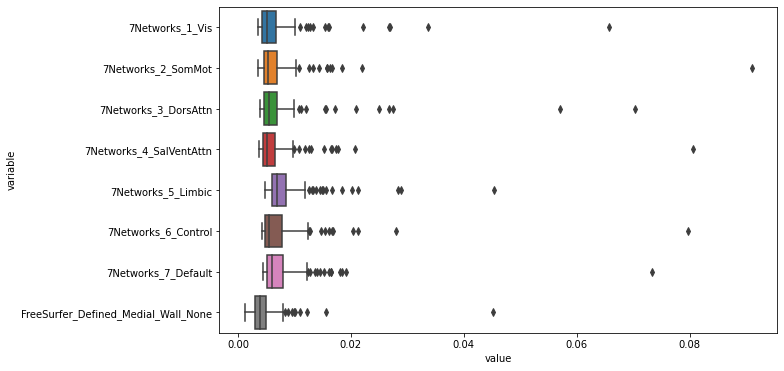

In [271]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
sns.boxplot(data=df_melted, x='value', y='variable')

<AxesSubplot:xlabel='value', ylabel='variable'>

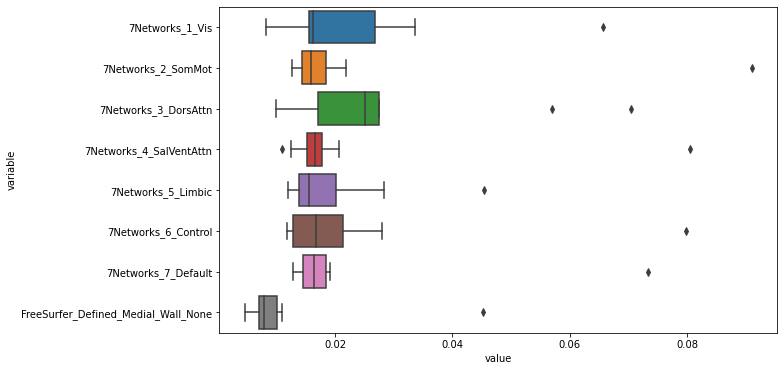

In [272]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
sns.boxplot(data=df_melted.loc[df_melted['component']<10], x='value', y='variable')

# Normalizing across the component

In [273]:
network_dist.shape
network_dist_sm = network_dist[:,0:-1]
df_network_pct = pd.DataFrame(network_dist_sm/network_dist_sm.sum(axis=1)[:,np.newaxis], columns=network_labels[0:-1], index=range(1,n_components+1))

<AxesSubplot:>

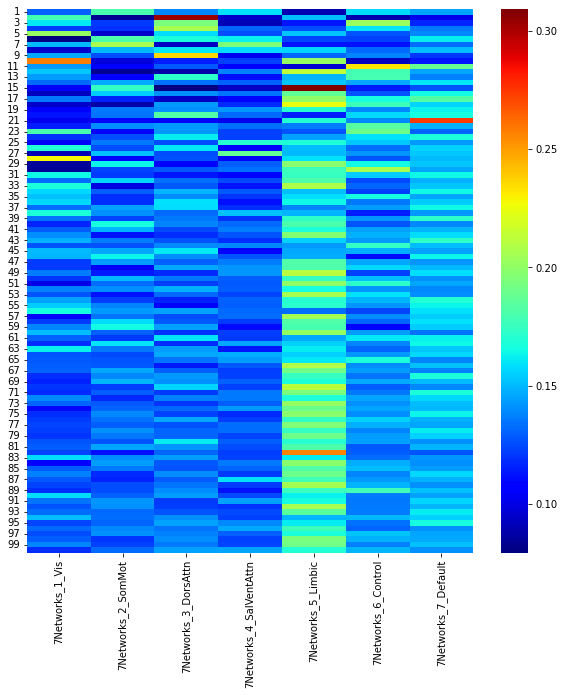

In [275]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(df_network_pct, cmap='Spectral')

# Permutation testing

In [59]:
#Define a fucntion to mix up the labels for logistic regression def permuteLabels(nTasks,nSubjects): 
# """shuffle the labels (y) of the data matrix (x) returns a mixed up labels vector to use for logistic regression permutation test Args: nTasks: scalar number of tasks in data set nSubjects: scalar numbher of subjects in data set where each subject completes each task once """ 
nTasks = 8
nSubjects = int(pca.components_.shape[0]/nTasks)
nIter = 100

In [60]:
no_comps_for_model = 100
scores_trunc = scores[:,0:no_comps_for_model]

In [61]:
Tasks = np.arange(nTasks)
sub = np.arange(nSubjects) 

rng = np.random.default_rng() 

perm_lr_scores = []
perm_no_unique_classes = []
#perm_lr_final_scores = np.zeros([nSubject])

for iperm in range(nIter):
    # empty array to store the permuted scores
    y= np.zeros((sub.shape[0],Tasks.shape[0]), dtype=int)

    # create a mixed up labels vector to use for logistic regression permutation test
    for i in sub: 
        y[i,:] = rng.permutation(Tasks)
        #fill a matrix where each row is one subject each collumn is random choice of task 
        yVect = np.reshape(y, y.shape[0]*y.shape[1], order='F')
        #New label Vector- stack collumns of y on top of each other return yVect 


    # Divide dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(scores, yVect, test_size=0.33, random_state=42, shuffle=True, stratify=labels)

    # Run logistic regression on the train set
    lr = LogisticRegressionCV(penalty='l1', solver='liblinear', max_iter=100, fit_intercept=True, random_state=42, cv=2).fit(X_train[:,0:no_comps_for_model], 
        y_train)

    # Predict on the test set
    #perm_lr_final_scores[iperm,:] = lr.predict(X_test[:,0:no_comps_for_model])
    perm_lr_scores.append(lr.score(X_test[:,0:no_comps_for_model], y_test))
    perm_no_unique_classes.append(np.unique(lr.predict(X_test[:,0:no_comps_for_model])).shape[0])

In [65]:
with open(os.path.join(datadir,'LR_perm.npy'), 'wb') as f:
    pickle.dump([perm_lr_scores, perm_no_unique_classes], f)

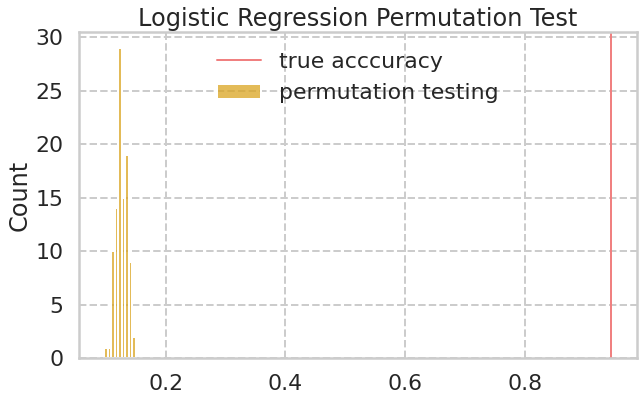

In [102]:
sns.set_theme(style='whitegrid', rc={'grid.linestyle': '--'},   context='poster')
fig, ax = plt.subplots(1,1,figsize=(10,6))
sns.histplot(x=perm_lr_scores, color='goldenrod',label = 'permutation testing')
plt.axvline(x=lr_scores[2], color = 'lightcoral', linewidth=2, label = 'true acccuracy')
ax.set_title('Logistic Regression Permutation Test')
l = ax.legend(frameon=False, loc='upper center')
plt.savefig(os.path.join(imgdir,'LR_perm_test.png'))

In [ ]:
X_train, X_test, y_train, y_test, lr_final_scores, lr_scores